# 1. Setup

In [1]:
from functools import reduce

from matplotlib_scalebar.scalebar import ScaleBar
from pqdm.processes import pqdm
from urllib.error import HTTPError
from scipy.spatial import KDTree
from shapely.geometry import Polygon

from utils import *

## 1.1. Parameters

In [2]:
# travel time thresholds (in minutes)
thresholds = (15, 30, 45, 60, 90)

In [3]:
# max. hypothetical speeds in mi/h
max_speeds = D(drive=60, bike=16, walk=4)

# 2. Prepare data

## 2.1. General

### 2.1.1. States & counties

In [4]:
state_list = (pd.read_csv('../data/zones/state_codes.csv')
              .sort_values('fips').head(51).pipe(lambda df: df[
                  ~df['name'].isin(['Alaska', 'Hawaii'])])).disp()

49 rows x 3 cols; Memory: 0.0 MiB


name      code     fips
   <object>  <object>  <int64>
0   Alabama        AL        1

In [5]:
us_counties = (gpd.read_parquet('../data/zones/us/county_trim.parquet')
               .rename(columns=D(geoid='cnty', name='county'))
               [['cnty', 'county', 'geometry']].set_crs(CRS_M)).disp()

3,108 rows x 3 cols; Memory: 0.4 MiB; CRS: EPSG:3857


cnty    county                                           geometry
   <object>  <object>                                         <geometry>
0     01001   Autauga  POLYGON ((-9624353.111696 3816718.739514, -962...

In [6]:
us_states = gpd.read_parquet('../data/zones/us/state_trim.parquet').set_crs(CRS_M).disp(0)

49 rows x 2 cols; Memory: 0.0 MiB; CRS: EPSG:3857


geoid    geometry
  <object>  <geometry>

### 2.1.2. Impedance function

In [7]:
df = pd.read_csv('../data/nhts/fitted-params-power-exponential.csv')
df = df.query('mode != "Transit" & measure == "Duration" & parameter != "r2"')
df = df.pivot_table('value', ['mode', 'purpose'], 'parameter').reset_index()
df['mode'] = df['mode'].str.lower()
df['purpose'] = (df['purpose'].str.lower()
                 .str.replace('social/recreational', 'leisure')
                 .str.replace('other services', 'services'))
imped_params = df.rename_axis(None, axis=1).disp()

15 rows x 4 cols; Memory: 0.0 MiB


mode   purpose      alpha       beta
   <object>  <object>  <float64>  <float64>
0      bike  services   0.039438   1.023212

## 2.2. Jobs (LEHD)

State codes downloaded from [here](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm).

In [8]:
def get_lehd_jobs(table, year=2021, state_list=state_list, overwrite=False):
    outpath = Path(f'../data/lehd/{table}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    assert table in ['rac', 'wac'], table
    root = 'https://lehd.ces.census.gov/data/lodes/LODES8'
    segments = D(S000='total', SE01='low_earn', SE03='high_earn')
    dfs = []
    for _, r in tqdm(state_list.iterrows(), total=len(state_list)):
        state = r['code'].lower()
        for seg_key, seg_name in segments.items():
            url = (f'{root}/{state}/{table}/'
                    f'{state}_{table}_{seg_key}_JT00_{year}.csv.gz')
            try:
                df = pd.read_csv(url)
            except HTTPError: # for AR & MS, latest data is for 2018
                df = pd.read_csv(url.replace(f'{year}', '2018'))
            except Exception as e:
                print(f'ERROR in {r["name"]}: {e}')
                continue
            df['geoid'] = df.iloc[:, 0].astype(str).str.zfill(15).str[:12]
            df = df.groupby('geoid')['C000'].sum().rename('jobs').reset_index()
            dfs.append(df.assign(segment=seg_name))
    df = pd.concat(dfs).pivot_table('jobs', 'geoid', 'segment', sort=False)
    df = df.fillna(0).astype(np.int32).reset_index().rename_axis(None, axis=1)
    df.to_parquet(mkfile(outpath))
    return df

rac = get_lehd_jobs('rac', overwrite=0).disp() # t=4:08
wac = get_lehd_jobs('wac', overwrite=0).disp(0) # t=2:02

236,651 rows x 4 cols; Memory: 20.1 MiB


geoid    total low_earn high_earn
       <object>  <int32>  <int32>   <int32>
0  010010201001      234       52       106

236,237 rows x 4 cols; Memory: 18.2 MiB


geoid    total low_earn high_earn
  <object>  <int32>  <int32>   <int32>

In [9]:
wac[['total','low_earn','high_earn']].sum()

total        139426864
low_earn      25280718
high_earn     73542672
dtype: int64

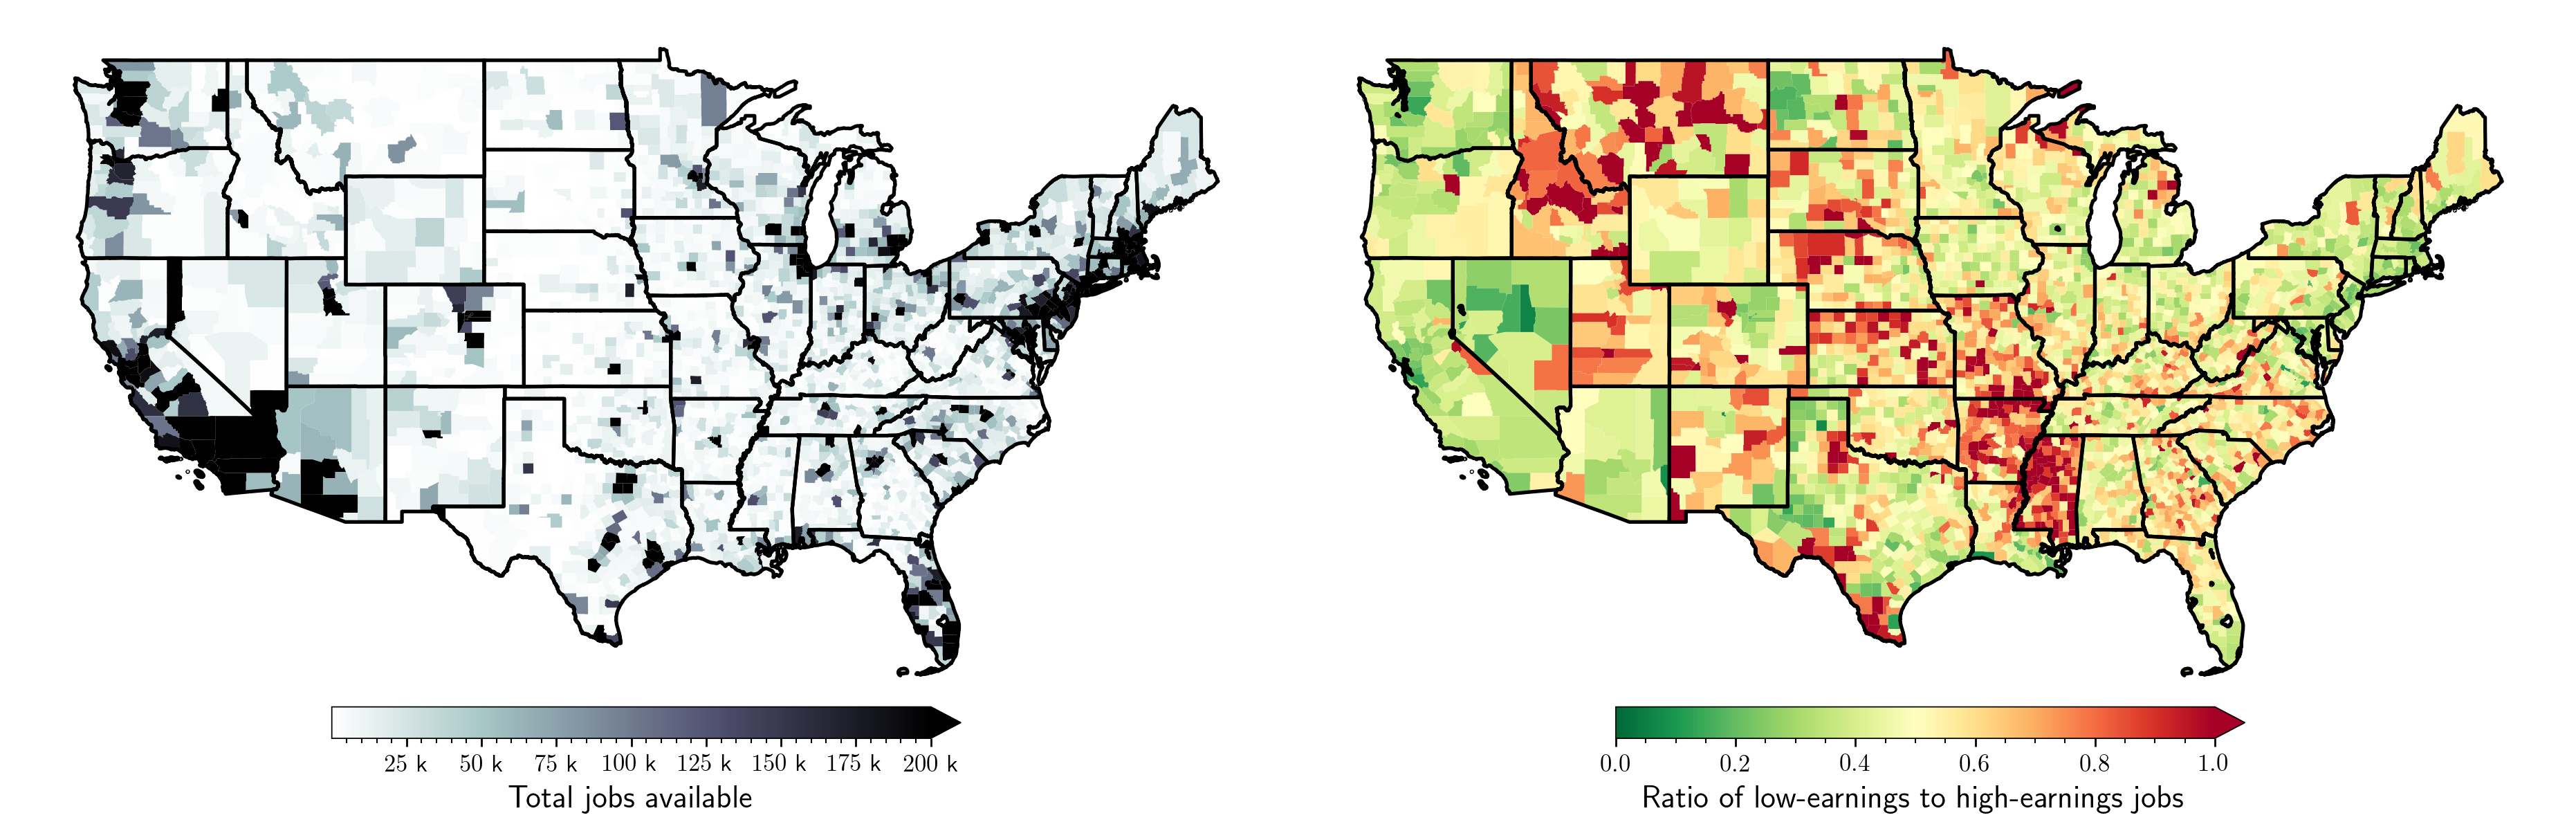

In [10]:
def fig_jobs_lodes(wac=wac, counties=us_counties, states=us_states):
    _, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=250)
    df = wac.assign(geoid=wac.geoid.str[:5]).groupby('geoid').sum().reset_index()
    df['ratio'] = df['low_earn'] / df['high_earn']
    df = counties.merge(df, left_on='cnty', right_on='geoid')
    ax = pplot(axes[0], axoff=1)
    df.plot(ax=ax, column='total', cmap='bone_r', legend=True, vmax=2e5,
            legend_kwds=D(shrink=0.5, label='Total jobs available',
                          orientation='horizontal', pad=0, extend='max',
                          format=mpl.ticker.EngFormatter()))
    states.plot(ax=ax, fc='none', ec='k', lw=1.5)
    ax = pplot(axes[1], axoff=1)
    df.plot(ax=ax, column='ratio', cmap='RdYlGn_r', legend=True, vmin=0, vmax=1,
            legend_kwds=D(shrink=0.5, orientation='horizontal', pad=0, extend='max',
                          label='Ratio of low-earnings to high-earnings jobs'))
    states.plot(ax=ax, fc='none', ec='k', lw=1.5)
    plt.tight_layout()

fig_jobs_lodes() # t=0:09

## 2.3. POIs (SafeGraph)

### 2.3.1. POI categories
Each SafeGraph POI category was manually classified by trip purpose and essentiality.

In [11]:
with open('../data/pois/poi_categories.yml', 'r') as f:
    cats = yaml.safe_load(f)['SafeGraph']
cats = Pdf(sum([[D(purpose=k, top_category=x) for x in v] 
                for k, v in cats.items()], []))
cats = cats.query('purpose != "Overall"').disp()

20 rows x 2 cols; Memory: 0.0 MiB


purpose             top_category
    <object>                 <object>
90  Services  Child Day Care Services

### 2.3.2. Count POIs by purpose & BG

In [12]:
def get_sg_poi_count(categories=cats, year=2020, overwrite=False):
    outpath = Path(f'../data/pois/sg_count_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    poi_path = '/home/umni2/a/umnilab/data/safegraph/pois/us/2020-11-06.parquet'
    zone_path = f'../data/zones/us/bg_{year}.parquet'
    poi = pd.read_parquet(poi_path, columns=['top_category', 'lon', 'lat'])
    poi = poi.merge(categories, 'left', on='top_category')
    poi = pdf2gdf(poi, 'lon', 'lat', CRS_DEG)
    bg = gpd.read_parquet(zone_path, columns=['geoid', 'geometry'])
    poi = poi.sjoin(bg, predicate='within')
    poi = pd.concat([
        poi.groupby(['purpose', 'geoid']).size().reset_index(),
        poi.groupby('geoid').size().reset_index().assign(purpose='Overall')
    ]).reset_index(drop=1).rename(columns={0: 'n_pois', 'geoid': 'cbg'})
    poi.to_parquet(mkfile(outpath))
    return poi

tot_poi = get_sg_poi_count(overwrite=0).disp() # t=0:44

681,065 rows x 3 cols; Memory: 91.8 MiB


purpose           cbg   n_pois
   <object>      <object>  <int64>
0   Leisure  010010201001        2

In [13]:
tot_poi.groupby('purpose')['n_pois'].sum().to_frame().T

purpose  Leisure  Overall  Services  Shopping
n_pois   1040318  5551806    559395    290096

### 2.3.3. Combine jobs & POIs

In [14]:
opport = pd.concat([
    wac.melt('geoid', var_name='kind', value_name='opport').assign(is_work=True),
    (tot_poi.rename(columns=D(cbg='geoid', purpose='kind', n_pois='opport'))
     .assign(is_work=False).assign(kind=lambda df: df.kind.str.lower()))
]).astype(D(opport=np.int32)).disp()
opport.astype(D(geoid=CAT, kind=CAT)).to_parquet('../data/opportunities.parquet')

1,389,776 rows x 4 cols; Memory: 194.0 MiB


geoid      kind   opport is_work
       <object>  <object>  <int32>  <bool>
0  010010201001     total      124    True

## 2.4. Compute accessibility
This only requires total jobs at the destination, not the OD flows.

In [15]:
def get_access(level, region, mode, thresh, year=2020, max_access=False,
               opport=opport, max_speeds=max_speeds, params=imped_params):
    cat_cols = 'region mode thresh purpose kind geoid'.split()
    opport = opport.groupby(['kind', 'is_work', 'geoid']).sum().reset_index()
    try:
        if max_access:
            zones = gpd.read_parquet(
                f'../data/zones/{level}_2020.parquet', filters=[
                    ('scale','==','bg'), ('region','==',region)]).to_crs(CRS_M)
            xy = zones.centroid.get_coordinates() # columns=['x','y']
            zones = pd.concat([zones[['geoid', 'geometry']], xy], axis=1)
            max_dist = (thresh * 60) * (max_speeds[mode] * MPH2MPS)
            tree = KDTree(zones[['x', 'y']])
            src, trg = [zones.loc[idx].reset_index(drop=1) for idx in 
                        tree.query_pairs(max_dist, output_type='ndarray').T]
            dist = ((src.x - trg.x) ** 2 + (src.y - trg.y) ** 2) ** 0.5
            time = (dist * M2MI / max_speeds[mode]) * 60 # time in minutes
            src, trg = src.geoid.values, trg.geoid.values
            nodes = list(set(src) | set(trg))
            time = (pd.concat([Pdf(D(src=nodes, trg=nodes, time=0)),
                               Pdf(D(src=src, trg=trg, time=time)),
                               Pdf(D(src=trg, trg=src, time=time))])
                    .astype(D(src=CAT, trg=CAT)))
            time = time.set_index(['src', 'trg'])['time'] / 60
        else:
            tt_file = f'../data/osrm/{level}/{region}/bg_{mode}_{year}.parquet'
            cols = D(src_geoid='src', trg_geoid='trg', duration='time')
            tt = pd.read_parquet(tt_file, columns=cols.keys()).rename(columns=cols)
            tt = tt.set_index(['src', 'trg'])['time'] / 60 # travel time in minutes
            time = tt[tt <= float(thresh)] # travel times for filtered OD pairs
        dfs = []
        for (is_work, kind), df in opport.groupby(['is_work', 'kind']):
            coef = params.query(f'mode=="{mode}"').set_index('purpose')
            row = coef.loc['work' if is_work else kind]
            od = np.exp(-row.alpha * time ** row.beta).rename('weight').reset_index()
            od = od.merge(df, left_on='trg', right_on='geoid')
            od['access'] = od['opport'] * od['weight']
            xs = od.groupby(['src', 'kind'])['access'].sum().reset_index()
            xs = xs.rename(columns=D(src='geoid'))
            xs = xs.assign(kind=kind, purpose='work' if is_work else 'nonwork')
            dfs.append(xs)
        xs = pd.concat(dfs).assign(region=region, mode=mode, thresh=str(thresh))
        xs = xs.astype(D(access=np.float32) | {x: CAT for x in cat_cols})
        xs = xs[cat_cols + ['access']]
    except Exception as e:
        print(type(e), e)
        xs = Pdf([], columns=cat_cols + ['access'])
    return xs

# x = get_access('state', 'arkansas', 'drive', 30).disp()
x = get_access('msa', 'austin', 'drive', 30).disp()
# xmax = get_access('msa', 'austin', 'drive', 60, max_access=True).disp()

9,079 rows x 7 cols; Memory: 0.3 MiB


region        mode      thresh     purpose        kind         geoid  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0      austin       drive          30     nonwork     leisure  480219501011   

      access  
   <float32>  
0  43.496021

In [16]:
def get_access_all(level, max_access=False, year=2020, thresholds=thresholds, 
                   njobs=16, overwrite=False):
    max_label = 'max_' if max_access else ''
    outpath = Path(f'../data/access/{max_label}{level}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    files = sorted(glob(f'../data/osrm/{level}/*/bg_*_{year}.parquet'))
    cases = sum([[D(level=level, region=f.split('/')[-2], thresh=t, year=year,
                    mode=f.split('/')[-1].split('_')[1], max_access=max_access)
                  for t in thresholds] for f in files], [])
    np.random.seed(1234)
    np.random.shuffle(cases) # shuffle to hopefully reduce parallel load
    print(len(cases))
    xs = pqdm(cases, get_access, n_jobs=njobs, argument_type='kwargs')
    cat_cols = 'region purpose kind mode thresh geoid'.split()
    xs = pd.concat(xs).reset_index(drop=1).astype(
        {x: CAT for x in cat_cols})[cat_cols + ['access']]
    xs.to_parquet(mkfile(outpath))
    return xs

xs_msa = get_access_all('msa', thresholds=thresholds, overwrite=0).disp() # t=17:55
xs_max_msa = get_access_all('msa', max_access=True, thresholds=thresholds, overwrite=0).disp(0) # t=27:38
xs_st = get_access_all('state', thresholds=[60], overwrite=0).disp(0) # t=6:17
xs_max_st = get_access_all('state', max_access=True, thresholds=[60], overwrite=0).disp(0) # t=15:14

12,956,475 rows x 7 cols; Memory: 172.8 MiB


region     purpose        kind        mode      thresh         geoid  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0     seattle     nonwork     leisure        bike          45  530330001011   

       access  
    <float32>  
0  363.534302

12,661,467 rows x 7 cols; Memory: 169.1 MiB


region     purpose        kind        mode      thresh       geoid  \
  <category>  <category>  <category>  <category>  <category>  <category>   

     access  
  <float32>

1,663,319 rows x 7 cols; Memory: 44.3 MiB


region     purpose        kind        mode      thresh       geoid  \
  <category>  <category>  <category>  <category>  <category>  <category>   

     access  
  <float32>

1,663,207 rows x 7 cols; Memory: 44.3 MiB


region     purpose        kind        mode      thresh       geoid  \
  <category>  <category>  <category>  <category>  <category>  <category>   

     access  
  <float32>

## 2.5. Export data

In [138]:
def export_access(xs_st=xs_st, xs_msa=xs_msa, thresh=('30', '60'),
                  kinds=D(total='work', overall='poi', shopping='shop', services='serv'),
                  counties=us_counties, state_codes=state_list, overwrite=False):
    outpath = Path('../us_bg_access_data.csv')
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath)
    bg = xs_st[['geoid']].drop_duplicates()
    msa = xs_msa[['geoid', 'region']].drop_duplicates()
    msa['msa'] = msa.region.str.replace('-', ' ').str.title()
    bg = bg.merge(msa[['geoid', 'msa']], 'left')
    bg['cnty'], bg['fips'] = bg.geoid.str[:5], bg.geoid.str[:2].astype(int)
    bg = bg.merge(counties[['cnty', 'county']])
    bg = bg.merge(state_codes, on='fips').drop(columns='fips')
    bg = bg.rename(columns=D(code='state', geoid='fips'))
    bg = bg[['fips', 'state', 'county', 'msa']]
    xs = pd.concat([xs_msa.query('mode != "drive"'), xs_st])
    xs = xs.drop(columns=['purpose', 'region'])
    xs = xs[(xs.thresh.isin(thresh)) & (xs.kind.isin(kinds.keys()))]
    xs['purpose'] = xs.pop('kind').map(kinds).astype(str)
    xs = xs.pivot_table('access', 'geoid', ['mode', 'purpose', 'thresh'])
    xs.columns = map('_'.join, xs.columns)
    xs.columns = ['_'.join(x) for x in xs.columns]
    xs = bg.merge(xs, left_on='fips', right_index=True)
    xs = xs.sort_values('fips').reset_index(drop=1)
    xs.to_csv(mkfile(outpath), index=False)
    return xs

xs_export = export_access(overwrite=0).disp() # t=0:09

237,617 rows x 24 cols; Memory: 77.2 MiB


fips     state    county       msa bike_poi_30 bike_poi_60  \
       <int64>  <object>  <object>  <object>   <float64>   <float64>   
0  10010201001        AL   Autauga       NaN         NaN         NaN   

  bike_serv_30 bike_serv_60 bike_shop_30 bike_shop_60  ... drive_shop_60  \
     <float64>    <float64>    <float64>    <float64>  ...     <float64>   
0          NaN          NaN          NaN          NaN  ...     53.220245   

  drive_work_60 walk_poi_30 walk_poi_60 walk_serv_30 walk_serv_60  \
      <float64>   <float64>   <float64>    <float64>    <float64>   
0      58324.05         NaN         NaN          NaN          NaN   

  walk_shop_30 walk_shop_60 walk_work_30 walk_work_60  
     <float64>    <float64>    <float64>    <float64>  
0          NaN          NaN          NaN          NaN  

[2 rows x 24 columns]

# 3. Analyze

In [17]:
chi_cnty = ('Cook', 'DuPage')
nyc_cnty = ('New York', 'Bronx', 'Queens', 'Kings', 'Richmond')
wash_cnty = ('District of Columbia', 'Arlington', 'Alexandria')

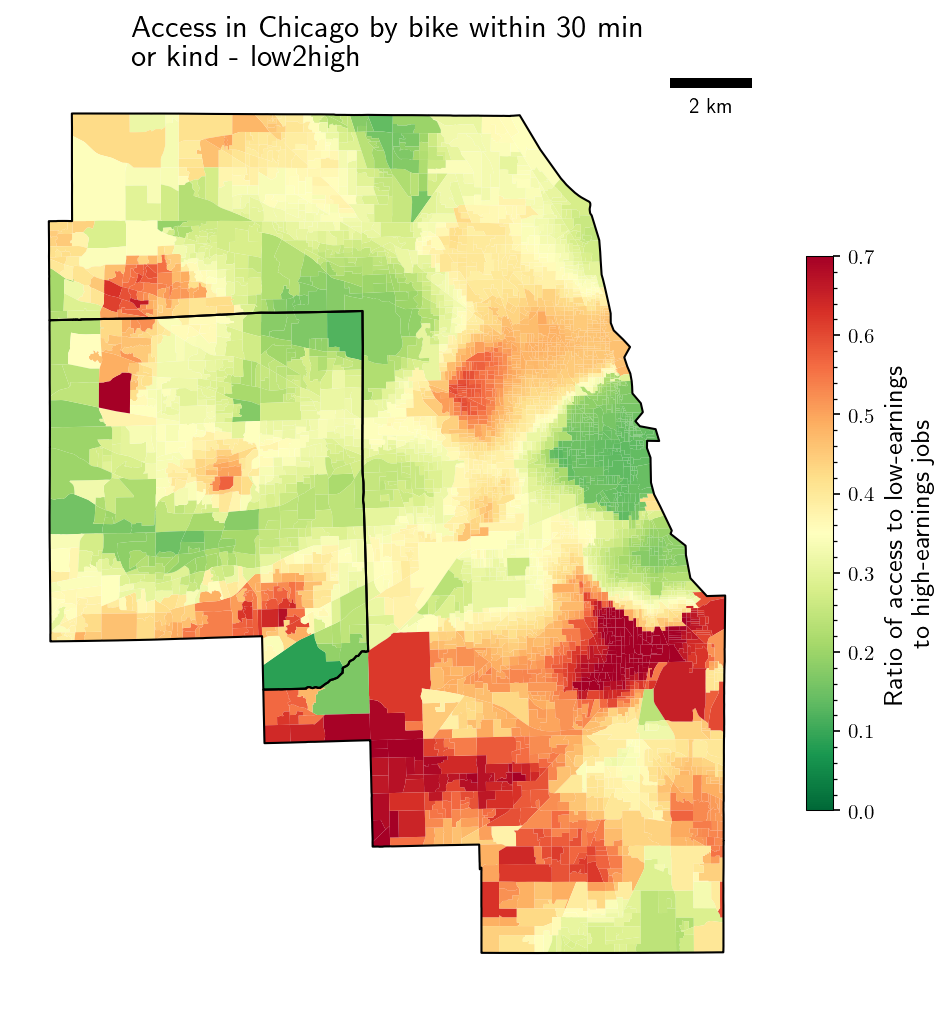

In [18]:
def plot_access_map(level, region, kind, mode, thresh, 
                    vmin=0, vmax=None, filt_counties=[], counties=us_counties,
                    size=(8, 8), dpi=150, cmap='gnuplot', save=False, show=True):
    xs = pd.read_parquet(f'../data/access/{level}_2020.parquet', filters=[
        ('region', '==', region), ('mode', '==', mode), ('thresh', '==', str(thresh))])
    if kind == 'low2high':
        low = xs[xs.kind == 'low_earn'].set_index('geoid')['access'].rename('low')
        high = xs[xs.kind == 'high_earn'].set_index('geoid')['access'].rename('high')
        xs = (low / high).rename('access').reset_index()
    elif kind == 'essential':
        ess = xs[xs.kind.isin(['shopping', 'services'])]
        ess = ess.astype(D(geoid=str)).groupby('geoid')['access'].mean()
        overall = xs[xs.kind == 'overall'].set_index('geoid')['access']
        xs = ((ess / overall).rename('access') * 100).reset_index()
    else:
        xs = xs[xs.kind == kind][['geoid', 'access']].reset_index(drop=1)
    bg = gpd.read_parquet(f'../data/zones/{level}_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', region)]).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg.merge(counties[['cnty', 'county']])
    if filt_counties:
        bg = bg[bg.county.isin(filt_counties)]
    cnty = counties[counties.cnty.isin(bg.cnty.unique())]
    xs = bg[['geoid', 'geometry']].merge(xs, on='geoid')
    title = 'Access in {} by {} within {} min\for kind - {}'.format(
        region.title().replace('-', ' '), mode, thresh, kind)
    ax = pplot(size=size, dpi=dpi, axoff=1, title=title)
    cmap = 'RdYlGn_r' if kind == 'low2high' or kind == 'essential' else cmap
    if kind == 'low2high': label = 'Ratio of access to low-earnings\nto high-earnings jobs'
    elif kind == 'essential': label = 'Percent of overall accessibility\ncovered by essentials'
    else: label = 'Accessibility (no. of opportunities)'
    xs.plot(ax=ax, column='access', vmin=vmin, vmax=vmax, legend=True,
            cmap=cmap, legend_kwds=D(shrink=0.6, label=label))
    cnty.to_crs(CRS_M).plot(ax=ax, fc='none', ec='k', lw=1)
    ax.add_artist(ScaleBar(0.2))
    if save: imsave(title, root='../fig/access', dpi=300)
    if not show: plt.close()

# x = plot_access_map('msa', 'indianapolis', 'essential', 'drive', 30); x
x = plot_access_map('msa', 'chicago', 'low2high', 'bike', 30, 0, 0.7, chi_cnty); x

In [19]:
# t=1:56
for level, rgn, kind, mode, thresh, vmin, vmax, counties in tqdm([
    # ('msa', 'chicago', 'essential', 'bike', 30, 5, 12, chi_cnty),
    # ('msa', 'chicago', 'essential', 'drive', 15, 5, 10, chi_cnty),
    # ('msa', 'chicago', 'essential', 'walk', 30, 2, 10, chi_cnty),
    # ('msa', 'chicago', 'low2high', 'bike', 30, 0.1, 0.8, []),
    # ('msa', 'chicago', 'low2high', 'drive', 30, 0.2, 0.6, []),
    # ('msa', 'chicago', 'low2high', 'drive', 60, 0.2, 0.6, []),
    # ('msa', 'chicago', 'shopping', 'bike', 30, None, None, chi_cnty),
    # ('msa', 'chicago', 'shopping', 'drive', 15, None, None, chi_cnty),
    # ('msa', 'chicago', 'total', 'drive', 60, None, None, []),
    # ('msa', 'houston', 'low2high', 'drive', 30, 0.2, 0.5, ['Harris']),
    # ('msa', 'indianapolis', 'high_earn', 'drive', 30, None, None, []),
    # ('msa', 'indianapolis', 'low_earn', 'drive', 30, None, None, []),
    # ('msa', 'indianapolis', 'low2high', 'drive', 30, 0.2, 0.5, []),
    # ('msa', 'los-angeles', 'low2high', 'drive', 30, 0.2, 0.5, []),
    # ('msa', 'los-angeles', 'total', 'drive', 30, None, None, []),
    # ('msa', 'new-york', 'essential', 'bike', 30, 5, 15, nyc_cnty),
    # ('msa', 'new-york', 'essential', 'drive', 30, 6, 8, nyc_cnty),
    # ('msa', 'new-york', 'leisure', 'walk', 30, None, None, nyc_cnty),
    # ('msa', 'new-york', 'low2high', 'bike', 30, 0.1, 0.6, nyc_cnty),
    # ('msa', 'new-york', 'low2high', 'drive', 30, 0.1, 0.3, nyc_cnty),
    # ('msa', 'new-york', 'low2high', 'drive', 60, 0.2, 0.45, []),
    # ('msa', 'new-york', 'overall', 'walk', 30, None, None, nyc_cnty),
    # ('msa', 'new-york', 'services', 'bike', 30, None, None, nyc_cnty),
    # ('msa', 'new-york', 'total', 'bike', 30, None, None, nyc_cnty),
    # ('msa', 'new-york', 'total', 'drive', 30, None, None, nyc_cnty),
    # ('msa', 'new-york', 'total', 'drive', 60, None, None, []),
    # ('msa', 'washington', 'low2high', 'bike', 30, 0.05, 0.2, wash_cnty),
    # ('msa', 'washington', 'total', 'bike', 30, None, None, wash_cnty),
    # ('state', 'california', 'low2high', 'drive', 60, 0, 1, []),
    # ('state', 'california', 'total', 'drive', 60, None, None, []),
    # ('state', 'illinois', 'low2high', 'drive', 60, 0.2, 0.7, []),
    # ('state', 'illinois', 'total', 'drive', 60, None, None, []),
    # ('state', 'indiana', 'low2high', 'drive', 60, 0.2, 0.7, []),
    # ('state', 'indiana', 'low2high', 'drive', 60, 0.2, 0.7, []),
    # ('state', 'indiana', 'overall', 'drive', 60, None, None, []),
    # ('state', 'indiana', 'total', 'drive', 60, None, None, []),
    # ('state', 'indiana', 'total', 'drive', 60, None, None, []),
    # ('state', 'ohio', 'low2high', 'drive', 60, 0.2, 0.7, []),
]):
    args = (level, rgn, kind, mode, thresh, vmin, vmax, counties)
    plot_access_map(*args, save=0, show=1)
    # plot_access_map(*args, save=1, show=0)

0it [00:00, ?it/s]

## 3.1. Flat cutoff vs decay

In [20]:
def get_flat_vs_decay(level, rgn, kind, mode, thresh, 
                      opport=opport, params=imped_params):
    purpose = 'work' if kind in ['total', 'low_earn', 'high_earn'] else kind
    params = params.query(f'mode=="{mode}" & purpose=="{purpose}"')
    alpha, beta = params.iloc[0].alpha, params.iloc[0].beta
    tt = pd.read_parquet('../data/osrm/{}/{}/bg_{}_2020.parquet'
                         .format(level, rgn, mode), filters=[
                             ('duration', '<=', thresh * 60)])
    tt = tt.assign(flat=1, decay=np.exp(-alpha * (tt.duration / 60) ** beta))
    df = opport.query(f'kind=="{kind}"')[['geoid', 'opport']]
    wt = tt.merge(df, left_on='trg_geoid', right_on='geoid')
    for col in ['flat', 'decay']: wt[col] *= wt['opport']
    xs = (wt.groupby('src_geoid')[['flat', 'decay']].sum()
          .rename_axis('geoid').reset_index())
    xs['pct_diff'] = (1 - xs.decay / xs.flat) * 100
    return xs

x = get_flat_vs_decay('msa', 'chicago', 'total', 'drive', 60).disp()

6,723 rows x 4 cols; Memory: 0.9 MiB


geoid     flat           decay   pct_diff
     <category>  <int64>       <float64>  <float64>
0  170310101001  3344784  1127190.561693  66.300049

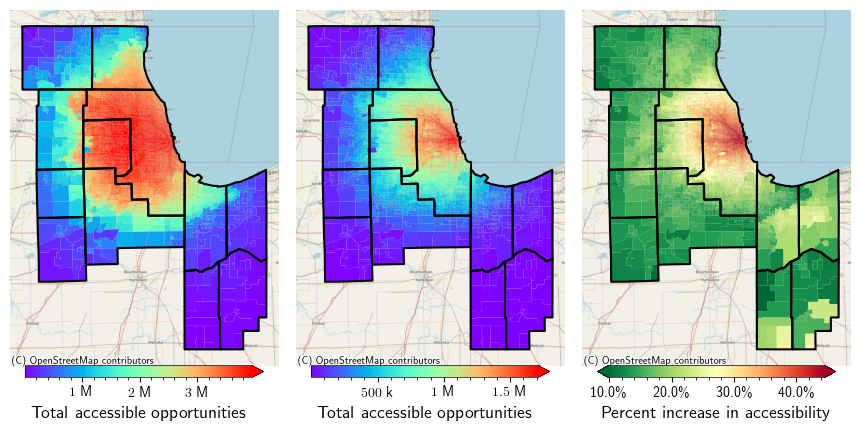

In [21]:
def plot_flat_vs_decay(level, rgn, kind, mode, thresh, filt_counties=[], 
                       size=(16, 7), dpi=100, cmap='rainbow', wspace=0, 
                       label='jobs', vmin=None, vmax=None, save=False, show=True):
    xs = get_flat_vs_decay(level, rgn, kind, mode, thresh)
    bg = gpd.read_parquet(f'../data/zones/{level}_2020.parquet',
                          filters=[('region', '==', rgn), ('scale', '==', 'bg')],
                          columns=['geoid', 'geometry']).to_crs(CRS_M)
    cnty = pd.read_parquet('../data/zones/us/county_trim.parquet', columns=[
        'geoid', 'name']).rename(columns=D(geoid='cnty_id', name='county'))
    if filt_counties:
        cnty = cnty[cnty['county'].isin(filt_counties)]
    bg = bg.assign(cnty_id=bg.geoid.str[:5]).merge(cnty, on='cnty_id')
    cnty = bg[['county', 'geometry']].dissolve('county').reset_index()
    xs = bg[['geoid', 'geometry']].merge(xs, on='geoid')
    fig, axes = plt.subplots(1, 3, figsize=size, dpi=300 if save else dpi)
    cbar_kwds = D(shrink=0.8, orientation='horizontal', pad=0)
    for col, ax in zip(['flat', 'decay'], axes[:2]):
        ax = pplot(ax, axoff=1)
        xs.plot(ax=ax, column=col, cmap=cmap, vmin=vmin, vmax=vmax,
                legend=True, legend_kwds=cbar_kwds | D(
                    format=mpl.ticker.EngFormatter(), extend='max',
                    label='Total accessible opportunities'))
    ax = pplot(axes[2], axoff=1)
    xs.pct_diff = 100 - xs.pct_diff
    xs.plot(ax=ax, column='pct_diff', cmap='RdYlGn_r', legend=True, 
            legend_kwds=cbar_kwds | D(
                format=mpl.ticker.PercentFormatter(), extend='both',
                label='Percent increase in accessibility'))
    for ax in axes:
        cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
    title = 'Accessibility to {} in {} by {} within {} min'.format(
        label, ' '.join([x.title() for x in rgn.split('-')]), mode, thresh)
    fig.subplots_adjust(wspace=wspace)
    fig.tight_layout()
    if save: imsave(title, root='../fig/flat_vs_decay')
    if not show: plt.close()

chi_cnty = 'Cook DuPage Grundy Jasper Kane Kendall Lake McHenry Newton Porter Will'.split()
plot_flat_vs_decay('msa', 'chicago', 'total', 'drive', 60, filt_counties=chi_cnty, 
                   wspace=-0.1, dpi=100, size=(9, 4.5))

In [22]:
# # t=2:52
# for level, rgn, kind, mode, thresh, label in tqdm([
#     ('state', 'indiana', 'total', 'drive', 60, 'jobs'),
#     ('msa', 'indianapolis', 'total', 'drive', 30, 'jobs'),
#     ('msa', 'indianapolis', 'total', 'walk', 60, 'jobs'),
#     ('msa', 'indianapolis', 'total', 'bike', 60, 'jobs'),
#     ('msa', 'indianapolis', 'overall', 'drive', 60, 'POIs'),
#     ('msa', 'chicago', 'total', 'drive', 60, 'jobs'),
#     ('msa', 'los-angeles', 'total', 'drive', 60, 'jobs'),
#     ('msa', 'san-francisco', 'total', 'drive', 60, 'jobs'),
#     ('msa', 'minneapolis', 'total', 'drive', 60, 'jobs'),
#     ('msa', 'st-louis', 'total', 'drive', 60, 'jobs'),
#     ('msa', 'boston', 'total', 'drive', 60, 'jobs'),
#     ('msa', 'detroit', 'total', 'drive', 60, 'jobs'),
# ]): plot_flat_vs_decay(level, rgn, kind, mode, thresh, label=label, save=1, show=0)

In [23]:
# t=0:41
chi = pd.concat([get_flat_vs_decay('msa', 'chicago', 'total', 'drive', t)
                 .assign(thresh=t) for t in tqdm(thresholds)]).dropna().disp()
chi.pct_diff = 100 - chi.pct_diff

  0%|          | 0/5 [00:00<?, ?it/s]

33,614 rows x 5 cols; Memory: 2.0 MiB


geoid     flat          decay   pct_diff   thresh
     <category>  <int64>      <float64>  <float64>  <int64>
0  170310101001   237098  188047.383645  20.687908       15

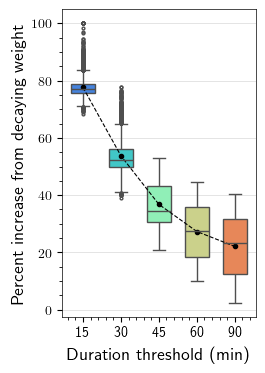

In [24]:
ax = pplot(size=(2.5, 4), dpi=100)
ax = sns.boxplot(chi, ax=ax, x='thresh', y='pct_diff', palette='rainbow', fliersize=2, gap=0.2)
ax = pplot(ax, xlab='Duration threshold (min)', ylab='Percent increase from decaying weight')
x = chi.groupby('thresh')['pct_diff'].mean()
ax.plot(range(len(x)), x.values, '--.', lw=0.8, color='k');

## 3.2. Access efficiency

In [25]:
test_msas = (
    ('houston', ['Harris']),
    ('new-york', ['New York', 'Bronx', 'Queens', 'Kings', 'Richmond']),
    ('chicago', ['Cook', 'DuPage']),
    # ('indianapolis', ['Marion']),
    # ('minneapolis', ['Hennepin', 'Ramsey']),
    # ('columbus', ['Franklin'])    
)

In [26]:
def plot_efficiency(level, rgn, counties=[], thresh=60, mode='drive', 
                    kind='total', us_counties=us_counties,
                    size=(8, 8), dpi=150, cmap='gnuplot',
                    vmin=None, vmax=None, alpha=1):
    bg = gpd.read_parquet(f'../data/zones/{level}_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', rgn)
    ], columns=['geoid', 'geometry']).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg.merge(us_counties[['cnty', 'county']])
    if counties: bg = bg[bg.county.isin(counties)]
    cnty = us_counties[us_counties.cnty.isin(bg.cnty)]
    xs = pd.merge(*[
        pd.read_parquet(f'../data/access/{label}{level}_2020.parquet', filters=[
            ('region', '==', rgn), ('thresh', '==', str(thresh)),
            ('mode', '==', mode), ('kind', '==', kind)],
                        columns=['geoid', 'access'])
        .rename(columns=D(access=xs_kind))
        for xs_kind, label in [('observed', ''), ('maximum', 'max_')]
    ], on='geoid').assign(pct=lambda df: df['observed'] / df['maximum'] * 100)
    xs = bg.merge(xs, on='geoid')
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs.plot(ax=ax, column='pct', legend=True, cmap=cmap, vmin=vmin, vmax=vmax,
            legend_kwds=D(shrink=0.7, label='Efficiency (\%)'), alpha=alpha)
    cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
    ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
    ax.add_artist(ScaleBar(0.3))

In [27]:
# x = plot_efficiency('msa', 'indianapolis', ['Marion'], 30, alpha=0.75, vmin=20, vmax=50, cmap='Spectral'); x

In [28]:
# plot_efficiency('msa', 'chicago', ['Lake', 'Porter', 'Jasper', 'Newton'], 30, alpha=0.75, vmin=0, vmax=30, cmap='Spectral')

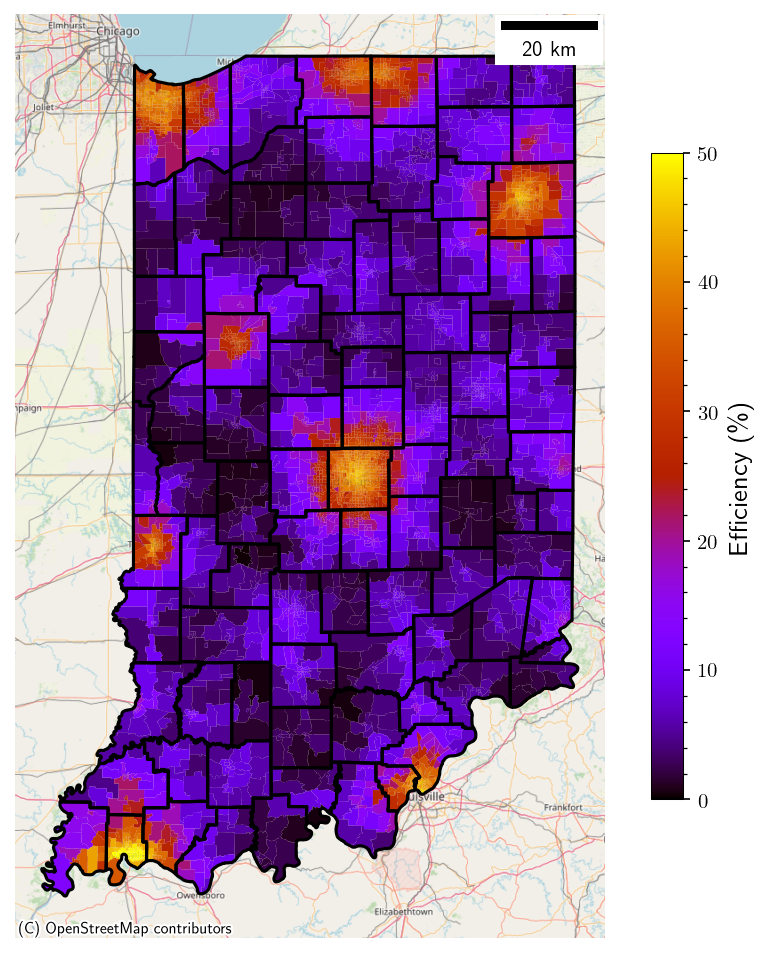

In [29]:
plot_efficiency('state', 'indiana', [], 60, vmin=0, vmax=50)

  0%|          | 0/3 [00:00<?, ?it/s]

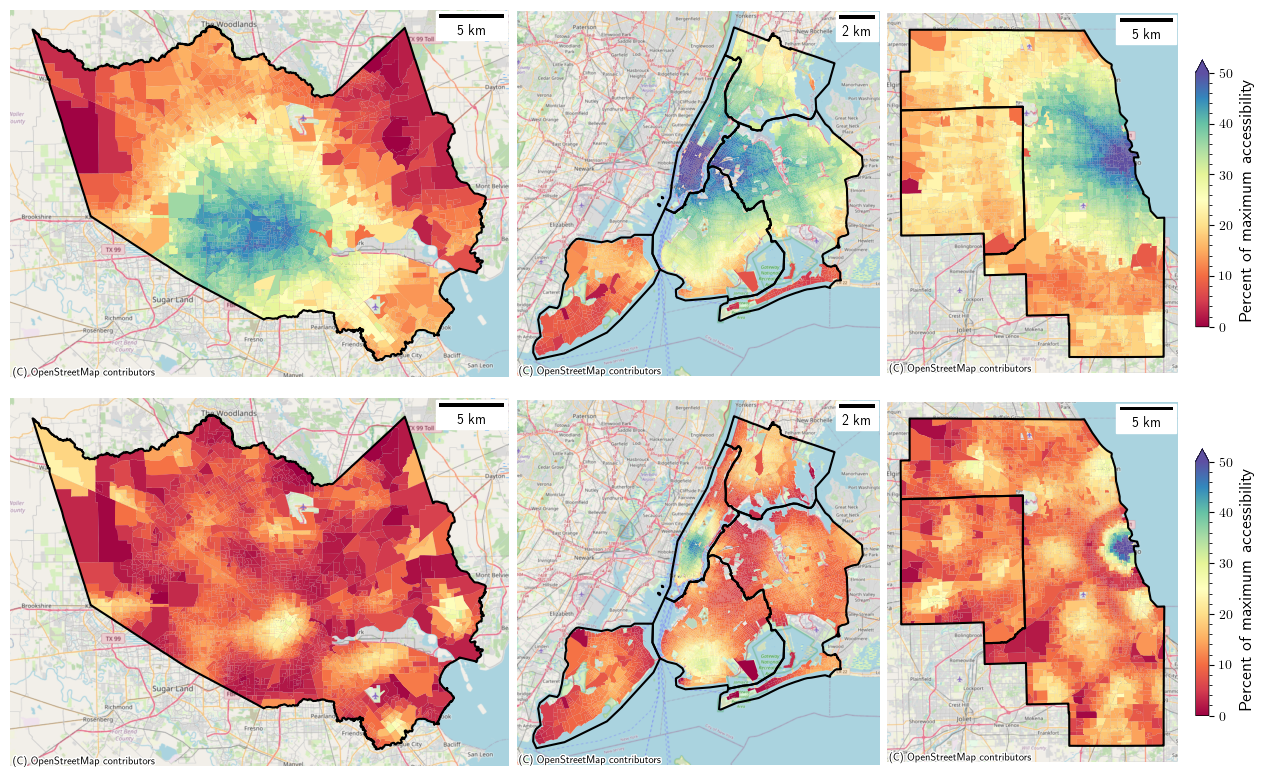

In [30]:
def plot_access_efficiency_map(msas=test_msas, obs_xs=xs_msa, max_xs=xs_max_msa,
                               thresh=30, vmin=0, vmax=50, us_counties=us_counties,
                               widths=(1.1, 0.8, 0.8), size=(16, 10), dpi=100):
    fig, axes = plt.subplots(2, 3, figsize=size, dpi=dpi, gridspec_kw=D(width_ratios=widths))
    for j, (rgn, counties) in enumerate(tqdm(msas)):
        zones = gpd.read_parquet('../data/zones/msa_2020.parquet', filters=[
            ('scale', '==', 'bg'), ('region', '==', rgn), ('aland', '>', 0)],
                                 columns=['geoid', 'geometry'])
        zones['cnty'] = zones.geoid.str[:5]
        zones = zones.merge(us_counties[['cnty', 'county']], on='cnty')
        zones = zones[zones.county.isin(counties)].to_crs(CRS_M)
        cnty = us_counties.merge(zones[['cnty']].drop_duplicates())
        popu = pd.read_parquet('../data/ses/acs_state_2021.parquet', filters=[
            ('scale', '==', 'bg')], columns=['geoid', 'popu'])
        zones = zones.merge(popu, on='geoid')
        zones['popu_wt'] = zones['popu'] / zones['popu'].sum()
        for i, mode in enumerate(['drive', 'bike']):
            xs = pd.merge(*[
                df.query(f'region=="{rgn}" & thresh=="{thresh}" & '
                         f'kind=="total" & mode=="{mode}"')
                [['geoid', 'access']].rename(columns=D(access=xs_kind))
                for xs_kind, df in [('observed', obs_xs), ('maximum', max_xs)]
            ], on='geoid')
            xs['pct'] = xs['observed'] / xs['maximum'] * 100
            xs = zones.merge(xs[['geoid', 'pct']])
            ax = pplot(axes[i, j], axoff=1)
            xs.plot(ax=ax, column='pct', legend=j == 2, cmap='Spectral', 
                    vmin=vmin, vmax=vmax, legend_kwds=D(
                        shrink=0.7, extend='max', label='Percent of maximum accessibility'))
            cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
            ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
            ax.add_artist(ScaleBar(0.3))
    fig.subplots_adjust(wspace=0.02, hspace=0.02)

plot_access_efficiency_map(dpi=100) # t=0:23

  0%|          | 0/3 [00:00<?, ?it/s]

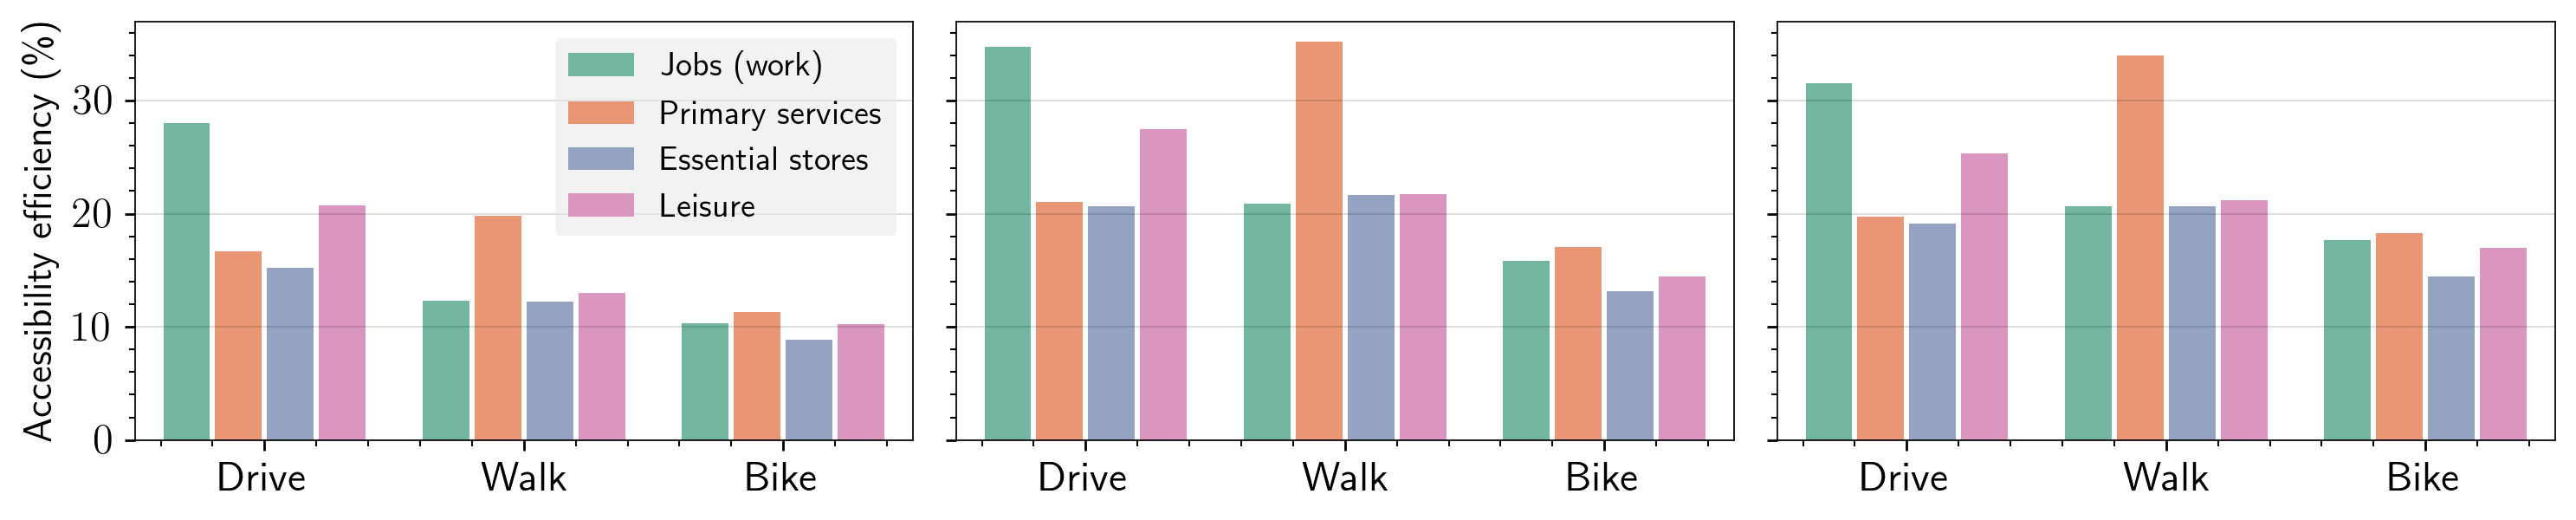

In [31]:
def plot_access_efficiency_bar(msas=test_msas, obs_xs=xs_msa, max_xs=xs_max_msa,
                               us_counties=us_counties, size=(12, 2.5), dpi=100):
    purposes = D(total='Jobs (work)', services='Primary services',
                 shopping='Essential stores', leisure='Leisure')
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi, sharey=True)
    for j, (rgn, filt_counties) in enumerate(tqdm(msas)):
        zones = gpd.read_parquet('../data/zones/msa_2020.parquet', filters=[
            ('scale', '==', 'bg'), ('region', '==', rgn), ('aland', '>', 0)],
                                 columns=['geoid', 'geometry'])
        zones['cnty'] = zones.geoid.str[:5]
        zones = zones.merge(us_counties[['cnty', 'county']], on='cnty')
        zones = zones[zones.county.isin(filt_counties)].to_crs(CRS_M)
        popu = pd.read_parquet('../data/ses/acs_state_2021.parquet', filters=[
            ('scale', '==', 'bg')], columns=['geoid', 'popu'])
        zones = zones.merge(popu, on='geoid')
        zones['popu_wt'] = zones['popu'] / zones['popu'].sum()
        xs = pd.merge(*[df.query(f'region=="{rgn}" & thresh=="30"')
                        .rename(columns=D(access=xs_kind))
                        [['kind', 'mode', 'geoid', xs_kind]]
                        for xs_kind, df in [('observed', obs_xs), ('maximum', max_xs)]
                        ], on=('kind', 'mode', 'geoid'))
        xs = zones[['geoid', 'popu_wt', 'geometry']].merge(xs, on='geoid')
        xs = xs.assign(kind=xs.kind.map(purposes), mode=xs['mode'].str.title()).dropna()
        xs['observed'] *= xs['popu_wt']
        xs['maximum'] *= xs['popu_wt']
        effic = xs.groupby(['kind', 'mode'])[['observed', 'maximum']].sum()
        effic = (effic['observed'] / effic['maximum'] * 100).rename('eta').reset_index()
        sns.barplot(effic, x='mode', y='eta', hue='kind', ax=axes[j],
                    palette='Set2', legend=j == 0, gap=0.1, alpha=1, 
                    order=['Drive', 'Walk', 'Bike'], hue_order=purposes.values())
        ax = pplot(axes[j], xlab='', ylab='Accessibility efficiency (\%)' if j == 0 else '')
        ax.tick_params(labelsize=14)
        leg = ax.get_legend()
        if leg: leg.set_title('')
        plt.tight_layout()

plot_access_efficiency_bar(dpi=250) # t=0:09

  0%|          | 0/2 [00:00<?, ?it/s]

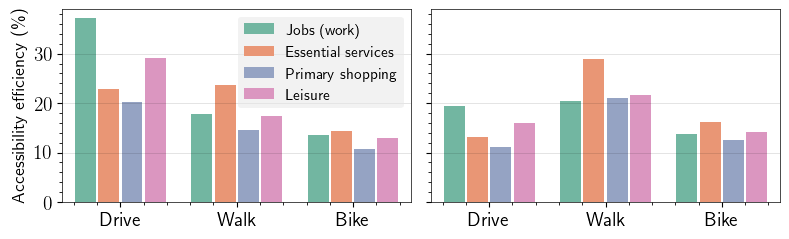

In [32]:
def plot_access_efficiency_bar2(obs_xs=xs_msa, max_xs=xs_max_msa, 
                                size=(8, 2.5), dpi=100, us_counties=us_counties, msas=[
        ('indianapolis', ['Marion']),
        ('chicago', ['Lake', 'Porter', 'Jasper', 'Newton'])
    ]):
    purposes = D(total='Jobs (work)', services='Essential services',
                 shopping='Primary shopping', leisure='Leisure')
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi, sharey=True)
    for j, (rgn, filt_counties) in enumerate(tqdm(msas)):
        zones = gpd.read_parquet('../data/zones/msa_2020.parquet', filters=[
            ('scale', '==', 'bg'), ('region', '==', rgn), ('aland', '>', 0)],
                                 columns=['geoid', 'geometry'])
        zones['cnty'] = zones.geoid.str[:5]
        zones = zones.merge(us_counties[['cnty', 'county']], on='cnty')
        zones = zones[zones.county.isin(filt_counties)].to_crs(CRS_M)
        popu = pd.read_parquet('../data/ses/acs_state_2021.parquet', filters=[
            ('scale', '==', 'bg')], columns=['geoid', 'popu'])
        zones = zones.merge(popu, on='geoid')
        zones['popu_wt'] = zones['popu'] / zones['popu'].sum()
        xs = pd.merge(*[df.query(f'region=="{rgn}" & thresh=="30"')
                        .rename(columns=D(access=xs_kind))
                        [['kind', 'mode', 'geoid', xs_kind]]
                        for xs_kind, df in [('observed', obs_xs), ('maximum', max_xs)]
                        ], on=('kind', 'mode', 'geoid'))
        xs = zones[['geoid', 'popu_wt', 'geometry']].merge(xs, on='geoid')
        xs = xs.assign(kind=xs.kind.map(purposes), mode=xs['mode'].str.title()).dropna()
        xs['observed'] *= xs['popu_wt']
        xs['maximum'] *= xs['popu_wt']
        effic = xs.groupby(['kind', 'mode'])[['observed', 'maximum']].sum()
        effic = (effic['observed'] / effic['maximum'] * 100).rename('eta').reset_index()
        sns.barplot(effic, x='mode', y='eta', hue='kind', ax=axes[j],
                    palette='Set2', legend=j == 0, gap=0.1, alpha=1, 
                    order=['Drive', 'Walk', 'Bike'], hue_order=purposes.values())
        ax = pplot(axes[j], xlab='', ylab='Accessibility efficiency (\%)' if j == 0 else '')
        ax.tick_params(labelsize=14)
        leg = ax.get_legend()
        if leg: leg.set_title('')
        plt.tight_layout()

plot_access_efficiency_bar2() # t=0:05

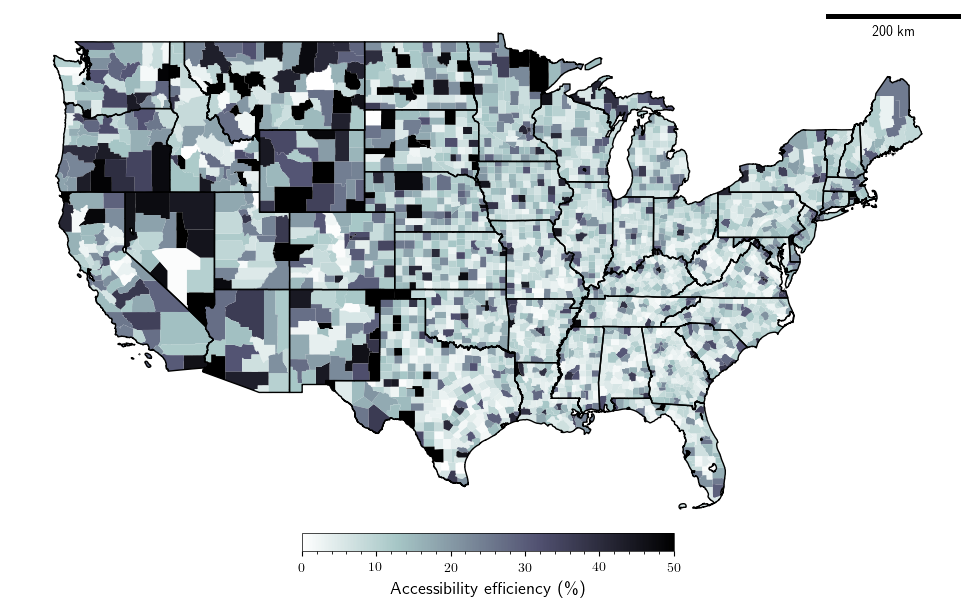

In [33]:
def plot_access_efficiency_map_us(obs_xs=xs_st, max_xs=xs_max_st, kind='total',
                                  vmin=0, vmax=50, size=(16, 8), dpi=100,
                                  counties=us_counties, states=us_states):
    obs_xs = (obs_xs.query(f'kind=="{kind}"')[['geoid', 'access']]
              .rename(columns=D(access='obs')))
    max_xs = (max_xs.query(f'kind=="{kind}"')[['geoid', 'access']]
              .rename(columns=D(access='max')))
    xs = pd.merge(obs_xs, max_xs, on='geoid')
    popu = pd.read_parquet('../data/ses/acs_state_2021.parquet', filters=[
        ('scale', '==', 'bg')], columns=['geoid', 'popu'])
    xs = xs.merge(popu, on='geoid')
    xs.geoid = xs.geoid.str[:5]
    for col in ['obs', 'max']: xs[col] *= xs['popu']
    xs = xs.groupby('geoid')[['obs', 'max']].sum().reset_index()
    xs['pct'] = xs['obs'] / xs['max'] * 100
    xs = counties.merge(xs, left_on='cnty', right_on='geoid')
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs.plot(ax=ax, column='pct', vmin=vmin, vmax=vmax, cmap='bone_r', 
            legend=True, legend_kwds=D(
                orientation='horizontal', shrink=0.3, pad=0,
                label='Accessibility efficiency (\%)'))
    states.plot(ax=ax, fc='none', ec='k', lw=1)
    ax.add_artist(ScaleBar(0.2))

x = plot_access_efficiency_map_us(dpi=100); x # t=0:04

In [34]:
# t=8:26
# for level, rgn, kind, mode, thresh, vmin, vmax, counties in tqdm([
#     ('msa', 'chicago', 'total', 'drive', 30, 10, 80, []),
#     ('msa', 'chicago', 'total', 'drive', 60, 10, 80, []),
#     ('msa', 'indianapolis', 'overall', 'drive', 30, 20, 60, ['Marion']),
#     ('msa', 'indianapolis', 'overall', 'walk', 30, 20, 60, ['Marion']),
#     ('msa', 'indianapolis', 'overall', 'bike', 30, 20, 60, ['Marion']),
#     ('msa', 'chicago', 'total', 'drive', 30, 10, 80, []),
#     ('msa', 'chicago', 'total', 'drive', 30, 10, 80, []),
#     ('msa', 'chicago', 'total', 'drive', 30, 10, 80, []),
#     ('msa', 'washington', 'leisure', 'walk', 30, 10, 80, ['District of Columbia']),
#     ('msa', 'washington', 'overall', 'drive', 30, 10, 60, ['District of Columbia']),
#     ('msa', 'washington', 'overall', 'bike', 30, 10, 60, ['District of Columbia']),
#     ('msa', 'houston', 'overall', 'bike', 30, 10, 60, ['Harris']),
#     ('msa', 'houston', 'overall', 'bike', 30, 10, 60, ['Harris']),
#     ('msa', 'houston', 'overall', 'drive', 30, 10, 60, ['Harris']),
#     ('msa', 'new-york', 'overall', 'drive', 30, 10, 60, ['New York','Bronx','Queens','Kings','Richmond']),
#     ('msa', 'new-york', 'overall', 'bike', 30, 10, 60, ['New York','Bronx','Queens','Kings','Richmond']),
#     ('state', 'indiana', 'total', 'drive', 60, 10, 80, []),
#     ('state', 'indiana', 'shopping', 'drive', 60, 10, 70, []),
#     ('state', 'massachusetts', 'shopping', 'drive', 60, 10, 80, []),
# ]): overall_vs_max_access(level, rgn, kind, mode, thresh, save=True, show=False,
#                           vmin=vmin, vmax=vmax, filt_counties=counties)

## 3.3. Opportunities

### 3.3.1. Regional zones of Cook County

In [35]:
bg_chi = gpd.read_parquet(f'../data/zones/msa_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', 'chicago')
        ], columns=['geoid', 'geometry']).to_crs(CRS_M)
bg_cook = bg_chi[bg_chi.geoid.str[:5] == '17031'].disp()

4,001 rows x 2 cols; Memory: 0.3 MiB; CRS: EPSG:3857


geoid                                           geometry
       <object>                                         <geometry>
0  170310101001  POLYGON ((-9759589.595086 5164433.147558, -975...

In [36]:
bound_cook = bg_cook.dissolve()

### 3.3.2. Regional zones of South Chicago

In [37]:
# zones of South Chicago
bg_schi = gpd.read_file('../data/ses/high_sedi_rgn_cook.gpkg').drop(columns='sedi').disp(0)

1,258 rows x 2 cols; Memory: 0.1 MiB; CRS: EPSG:3857


geoid    geometry
  <object>  <geometry>

In [38]:
poly = bg_schi.dissolve().geometry.iloc[0]
poly = reduce(lambda x, y: x.union(Polygon(y)), list(poly.interiors), poly)
bound_schi = Gdf(D(geometry=[poly]), crs=CRS_M)

### 3.3.3. SEDI values

In [39]:
def get_sedi(bgs, rank=True, cols=(
        'p_poc p_pov p_snglparent p_crowded p_lowedu p_renter '
        'p_noveh p_noinsur p_lowenglish p_disabled p_unemploy').split()):
    ses = pd.read_parquet('../data/ses/acs_state_2021.parquet')
    ses = ses[['geoid', 'popu'] + cols]
    ses = bgs[['geoid']].merge(ses, on='geoid').fillna(0)
    if rank:
        sedi = ses[cols].rank(pct=True).assign(geoid=ses.geoid)
    sedi['sedi'] = ses[cols].mean(axis=1).rank(pct=True)
    sedi = (bgs[['geoid', 'geometry']].merge(sedi[['geoid', 'sedi']])
            .merge(ses[['geoid', 'popu']]))
    return sedi

cols = 'p_pov p_poc p_unemploy p_lowedu p_noveh p_snglparent'.split()
sedi_cook = get_sedi(bg_cook, cols=cols).disp(0)
sedi_schi = get_sedi(bg_schi, cols=cols).disp(0)

3,992 rows x 4 cols; Memory: 0.4 MiB; CRS: EPSG:3857


geoid    geometry       sedi       popu
  <object>  <geometry>  <float64>  <float64>

1,258 rows x 4 cols; Memory: 0.1 MiB; CRS: EPSG:3857


geoid    geometry       sedi       popu
  <object>  <geometry>  <float64>  <float64>

### 3.3.4. Improvement potential gradient

In [40]:
def get_xs_gradient(sedi, level, rgn, kind, mode, thresh, popu_wt='popu', params=imped_params):
    assert popu_wt in ['popu', 'sedi']
    ses = sedi.assign(ses_wt=sedi.popu * sedi.sedi if popu_wt == 'sedi' else sedi.popu)
    ses['ses_wt'] /= ses['ses_wt'].sum()
    purpose = 'work' if kind in ['total', 'low_earn', 'high_earn'] else kind
    params = params.query(f'mode=="{mode}" & purpose=="{purpose}"')
    alpha, beta = params.iloc[0][['alpha', 'beta']]
    od = pd.read_parquet(f'../data/osrm/{level}/{rgn}/bg_{mode}_2020.parquet',
                         filters=[('duration', '<=', thresh * 60)])
    od = od.rename(columns=D(src_geoid='src', trg_geoid='trg'))
    od = od.merge(ses.geoid.rename('src')).merge(ses.geoid.rename('trg'))
    od = od.astype(D(src=CAT, trg=CAT)).drop(columns='distance')
    od['time_wt'] = np.exp(-alpha * (od.pop('duration') / 60) ** beta)
    grad = od.merge(ses[['geoid', 'ses_wt']].rename(columns=D(geoid='trg')))
    grad['weight'] = grad['time_wt'] * grad['ses_wt']
    grad = grad.groupby('src')['weight'].sum().rename_axis('geoid').reset_index()
    grad = ses[['geoid', 'geometry']].merge(grad, on='geoid')
    grad.weight = grad.weight.rank(pct=True)
    return grad

args = ('msa', 'chicago', 'shopping', 'drive', 30)
grad_cook_popu = get_xs_gradient(sedi_cook, *args, popu_wt='popu').disp() # t=0:09
grad_cook_sedi = get_xs_gradient(sedi_cook, *args, popu_wt='sedi') # t=0:09
grad_schi_popu = get_xs_gradient(sedi_schi, *args, popu_wt='popu') # t=0:04
grad_schi_sedi = get_xs_gradient(sedi_schi, *args, popu_wt='sedi') # t=0:04

3,992 rows x 3 cols; Memory: 0.3 MiB; CRS: EPSG:3857


geoid                                           geometry     weight
       <object>                                         <geometry>  <float64>
0  170310101001  POLYGON ((-9759589.595086 5164433.147558, -975...   0.429609

### 3.3.5. Difference in improvement potential

In [41]:
def get_grad_diff(df_popu, df_sedi):
    df_popu = df_popu.assign(popu=df_popu.weight.rank(pct=True))
    df_sedi = df_sedi.assign(sedi=df_sedi.weight.rank(pct=True))
    df = df_popu.merge(df_sedi[['geoid', 'sedi']], on='geoid')
    df['delta'] = df.sedi - df.popu
    return df

grad_cook_delta = get_grad_diff(grad_cook_popu, grad_cook_sedi).disp()
grad_schi_delta = get_grad_diff(grad_schi_popu, grad_schi_sedi)

3,992 rows x 6 cols; Memory: 0.4 MiB; CRS: EPSG:3857


geoid                                           geometry     weight  \
       <object>                                         <geometry>  <float64>   
0  170310101001  POLYGON ((-9759589.595086 5164433.147558, -975...   0.429609   

        popu       sedi      delta  
   <float64>  <float64>  <float64>  
0   0.429609   0.316633  -0.112976

### 3.3.6. Plot the improvement potential

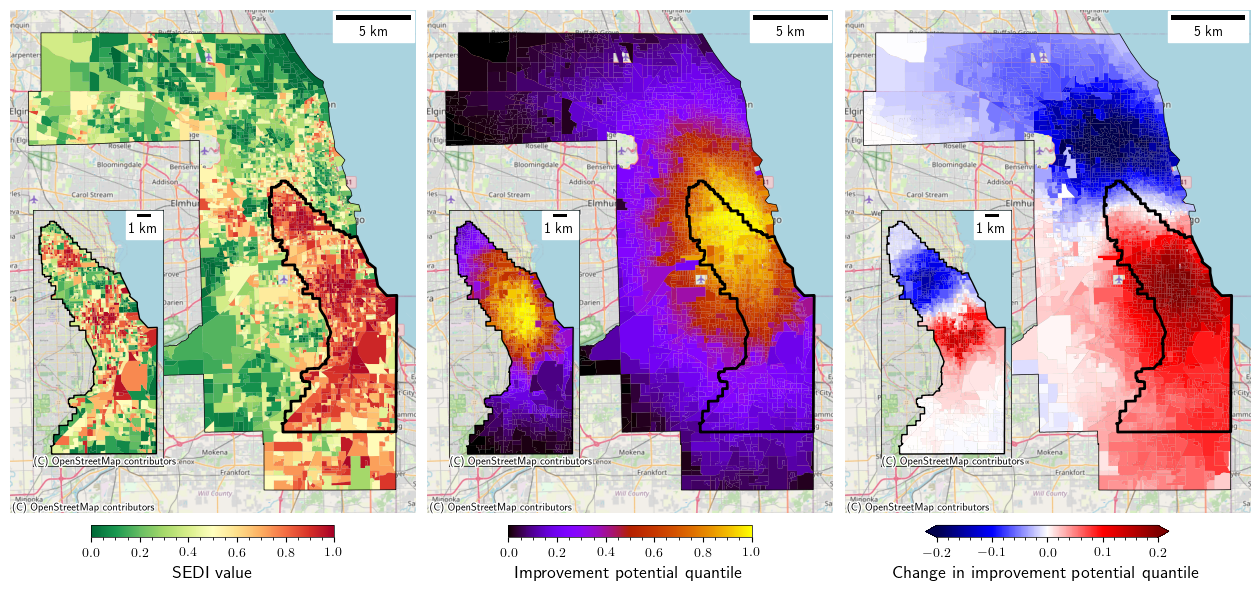

In [42]:
def fig_improvement_potential(size=(16, 8), dpi=250):
    fig, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    ax1, ax2, ax3 = [pplot(ax, axoff=1) for ax in axes]
    
    def main_plot(ax, df, column, cmap, vmin, vmax, label, extend=None):
        df.plot(ax=ax, column=column, cmap=cmap, legend=True, 
                vmin=vmin, vmax=vmax, legend_kwds=D(
                    label=label, shrink=0.6, orientation='horizontal', 
                    pad=0.02, extend=extend))
        bound_cook.plot(ax=ax, fc='none', ec='k', lw=0.5)
        bound_schi.plot(ax=ax, fc='none', ec='k', lw=2)
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
        ax.add_artist(ScaleBar(0.3))
    main_plot(ax1, sedi_cook, 'sedi', 'RdYlGn_r', 0, 1, 'SEDI value')
    main_plot(ax2, grad_cook_sedi, 'weight', 'gnuplot', 0, 1,
              label='Improvement potential quantile')
    main_plot(ax3, grad_cook_delta, 'delta', 'seismic', -0.2, 0.2,
              label='Change in improvement potential quantile', extend='both')
    
    def inset_plot(bbox, df, column, cmap, vmin, vmax, **kw):
        ax = fig.add_subplot(bbox)
        df.plot(ax=ax, column=column, cmap=cmap, vmin=vmin, vmax=vmax, **kw)
        bound_schi.plot(ax=ax, fc='none', ec='k', lw=1)
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([]); ax.set_yticks([])
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
        ax.add_artist(ScaleBar(0.3))
    inset_plot([0.13, 0.3, 0.1, 0.32], sedi_schi, 'sedi', 'RdYlGn_r', 0, 1)
    inset_plot([0.39, 0.3, 0.1, 0.32], grad_schi_sedi, 'weight', 'gnuplot', 0, 1)
    inset_plot([0.66, 0.3, 0.1, 0.32], grad_schi_delta, 'delta', 'seismic', -0.2, 0.2)
    fig.subplots_adjust(wspace=0.03)

fig_improvement_potential(dpi=100) # t=0:13